✅ Dataset loaded successfully!
Shape of dataset: (1470, 35)
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   

   TotalWorkingYears  TrainingTimesLastYear WorkL

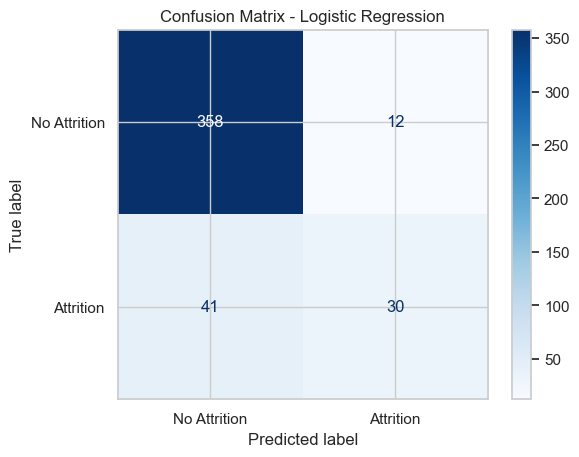


🚀 Training model: Decision Tree

================ Decision Tree ================
F1 Score: 0.26
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       370
           1       0.25      0.27      0.26        71

    accuracy                           0.76       441
   macro avg       0.56      0.56      0.56       441
weighted avg       0.76      0.76      0.76       441

Confusion Matrix:
 [[314  56]
 [ 52  19]]


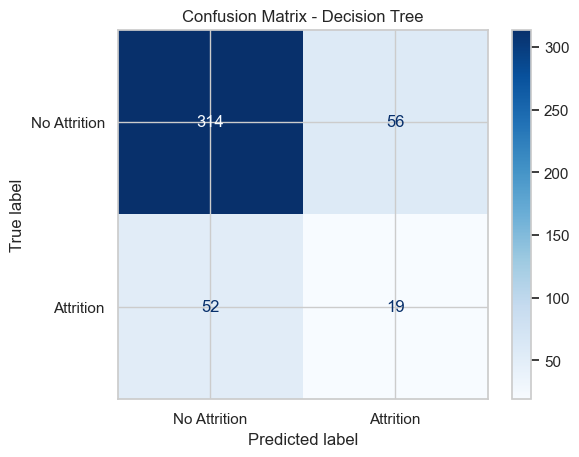


🚀 Training model: Random Forest

================ Random Forest ================
F1 Score: 0.255
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       370
           1       0.52      0.17      0.26        71

    accuracy                           0.84       441
   macro avg       0.69      0.57      0.58       441
weighted avg       0.80      0.84      0.81       441

Confusion Matrix:
 [[359  11]
 [ 59  12]]


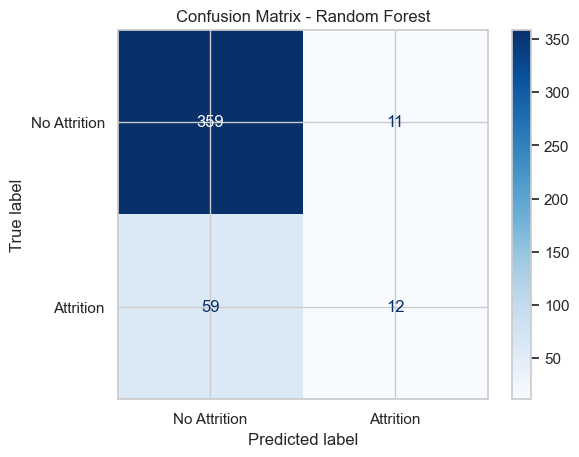

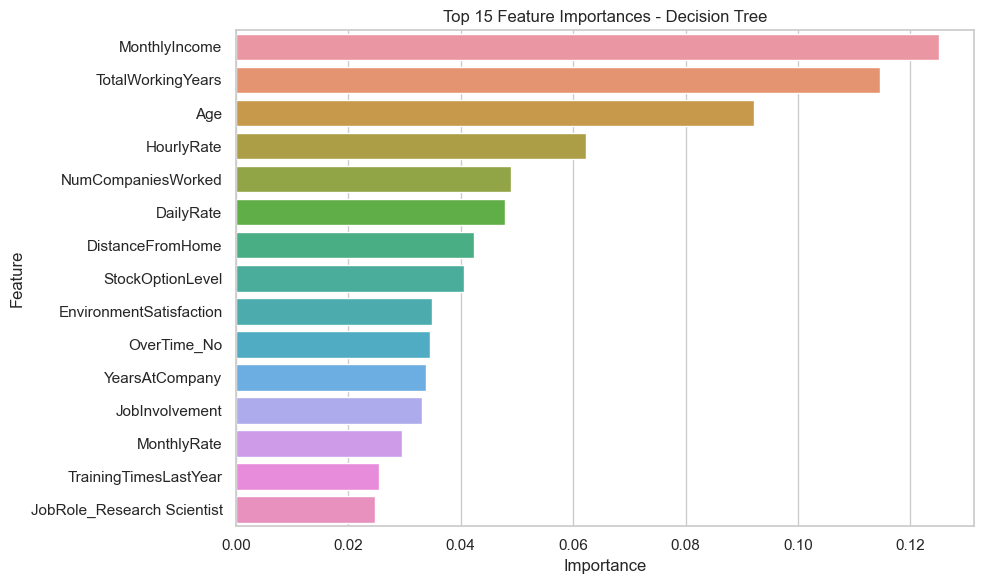

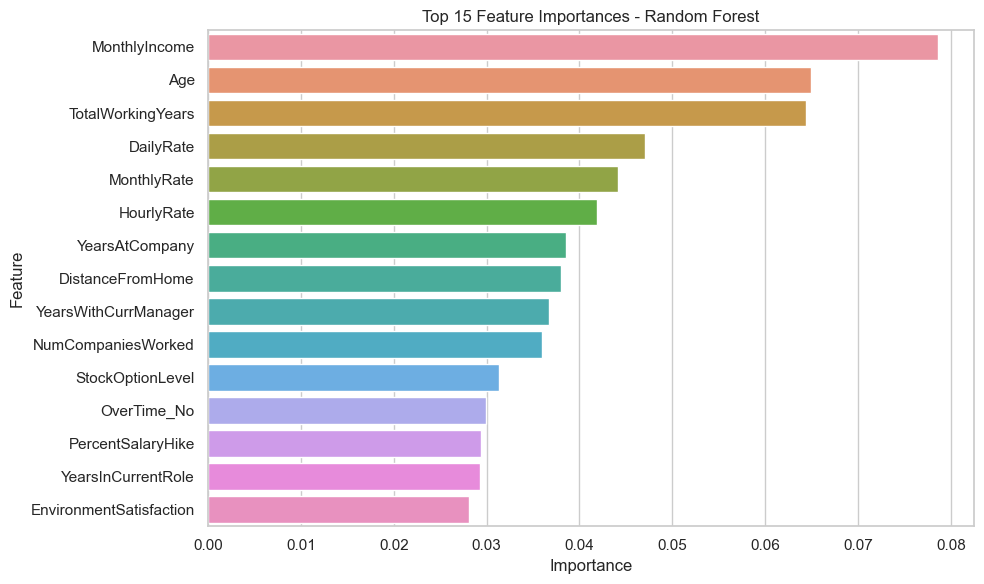

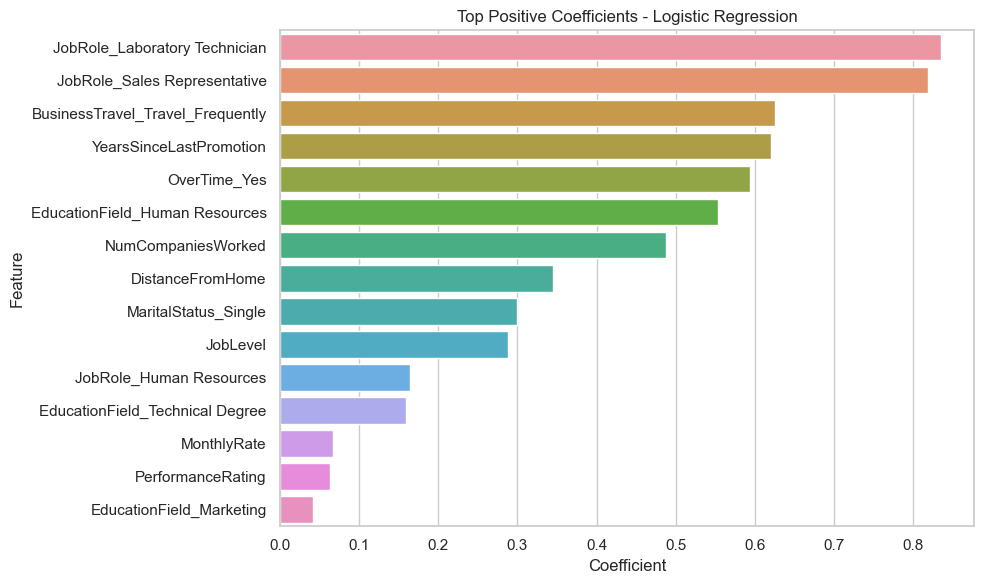

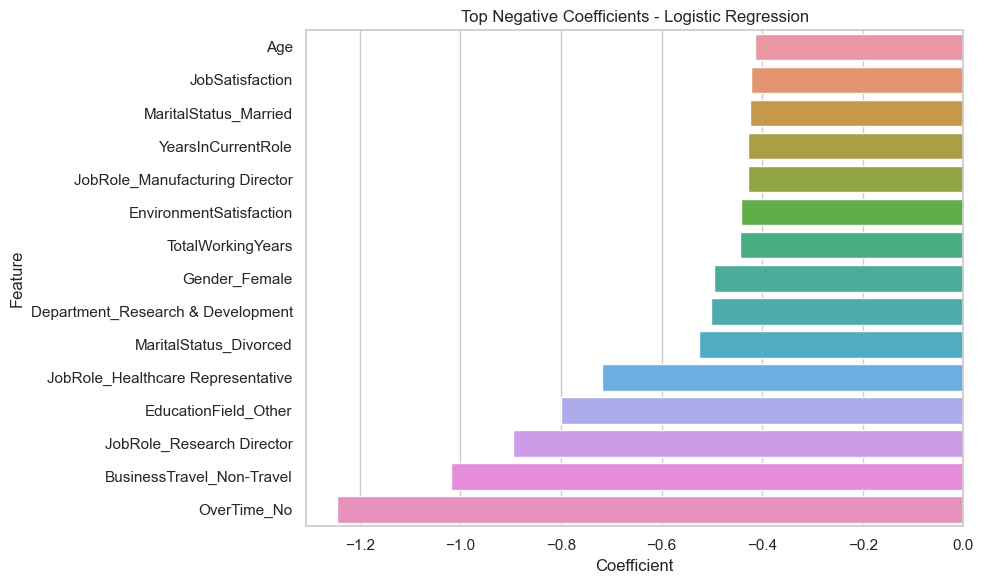


📈 Final Model Comparison:
                  Model  F1 Score
0  Logistic Regression     0.531
1        Decision Tree     0.260
2        Random Forest     0.255

✅ All models trained, evaluated, visualized, and saved successfully!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from packaging import version

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import joblib

sns.set(style="whitegrid")

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print("✅ Dataset loaded successfully!")
print("Shape of dataset:", df.shape)
print(df.head(3))


# --- Check for null values ---
print("\n🔍 Checking for missing values...")
print(df.isnull().sum().sort_values(ascending=False).head(10))
# (If any missing values exist, they’ll be handled in preprocessing pipelines.)

# --- Check for duplicates ---
duplicate_count = df.duplicated().sum()
print(f"\n🔁 Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed. New shape:", df.shape)

# Drop irrelevant or constant columns

# We drop columns that provide no predictive information:
# EmployeeNumber → ID field (unique per employee, not predictive)
#  StandardHours → Same value (80) for everyone → no variance → useless
#  Over18 → Constant ('Y') → no variance → useless
#  EmployeeCount → Always 1 → constant → useless
drop_cols = ['EmployeeNumber', 'StandardHours', 'Over18', 'EmployeeCount']
df.drop(columns=drop_cols, inplace=True)
print("\n🧹 Dropped irrelevant columns:", drop_cols)


# STEP 4: Encode target variable

# Convert Attrition: Yes → 1, No → 0
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
print("\n🎯 Converted target column ‘Attrition’ to numeric.")

# STEP 5: Split features and target

X = df.drop(columns=['Attrition'])
y = df['Attrition']

# Detect numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("\n🔢 Numeric features:", numeric_features)
print("🔠 Categorical features:", categorical_features)

# ============================================================
# STEP 6: Preprocessing pipelines (core integration step)
# ============================================================

# ---------------- NUMERIC PREPROCESSING ----------------
# We use a pipeline for numeric features:
#   1️⃣ SimpleImputer(strategy='median'): replaces missing numeric values with the median (robust to outliers)
#   2️⃣ StandardScaler(): normalizes all numeric features (mean=0, std=1)
#                        → helps models like Logistic Regression converge properly
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handles missing numeric values
    ('scaler', StandardScaler())                    # Normalizes feature scale
])

# ---------------- CATEGORICAL PREPROCESSING ----------------
# We use a pipeline for categorical features:
# SimpleImputer(strategy='most_frequent'):
# → Fills missing categorical values with the most common one
#   so no data is lost and model sees complete inputs.

# OneHotEncoder(handle_unknown='ignore', sparse_output=False):
# → Converts text categories into numeric 0/1 columns
#   so ML models can understand them, and ignores unseen categories during prediction.
#   handle_unknown='ignore': avoids errors if unseen category appears during prediction
#   sparse_output=False: returns dense DataFrame, easier to merge with numeric data
ohe_kwargs = {'handle_unknown': 'ignore'}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handles missing categorical values
    ('onehot', OneHotEncoder(**ohe_kwargs))                # Encodes text categories
])

# Combine both numeric and categorical transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("\n⚙️ Preprocessing pipelines created successfully!")

# ============================================================
# STEP 7: Train-test split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("\n📊 Training data shape:", X_train.shape)
print("📊 Testing data shape:", X_test.shape)



# Using three models to compare:
# - Logistic Regression: interpretable baseline, good for linear patterns
# - Decision Tree: captures nonlinear patterns, easy to interpret
# - Random Forest: ensemble method → higher accuracy, less overfitting
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}



results = {}

for name, model in models.items():
    print(f"\n🚀 Training model: {name}")
    
    # Combine preprocessing + model into one pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Train on training data
    clf.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = clf.predict(X_test)
    
    # Evaluate performance
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    # Save results
    results[name] = {'model': clf, 'f1': f1, 'cm': cm, 'report': report}
    
    # Display evaluation metrics
    print(f"\n================ {name} ================")
    print("F1 Score:", round(f1, 3))
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)
    
    # Visualize confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Attrition', 'Attrition'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # Save model
    joblib.dump(clf, f'pipeline_{name.replace(" ", "_")}.joblib')

# ============================================================
# STEP 10: Feature Importance Visualization
# ============================================================

# --- Tree-based Models ---
for name in ['Decision Tree', 'Random Forest']:
    model = results[name]['model']['classifier']
    
    # Get final feature names after preprocessing
    feature_names = (
        numeric_features +
        list(results[name]['model']['preprocessor']
             .named_transformers_['cat']
             .named_steps['onehot']
             .get_feature_names_out(categorical_features))
    )
    
    # Create dataframe of top features
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False).head(15)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Top 15 Feature Importances - {name}')
    plt.tight_layout()
    plt.show()

# --- Logistic Regression Coefficients ---
log_model = results['Logistic Regression']['model']['classifier']
feature_names = (
    numeric_features +
    list(results['Logistic Regression']['model']['preprocessor']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': log_model.coef_[0]})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

# Top positive & negative coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
plt.title('Top Positive Coefficients - Logistic Regression')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.tail(15))
plt.title('Top Negative Coefficients - Logistic Regression')
plt.tight_layout()
plt.show()

# ============================================================
# STEP 11: Summary Comparison
# ============================================================

summary = pd.DataFrame({
    'Model': list(results.keys()),
    'F1 Score': [round(results[m]['f1'], 3) for m in results]
}).sort_values(by='F1 Score', ascending=False)

print("\n📈 Final Model Comparison:\n", summary)
print("\n✅ All models trained, evaluated, visualized, and saved successfully!")


In [ ]:
# 📊 MODEL COMPARISON & SELECTION

# --- Logistic Regression ---
#  F1 Score: 0.531 (highest among the three)
# Accuracy: 0.88
# Performs well for both classes with balanced precision/recall
#  Slightly misses some attrition (class 1) cases → recall = 0.42
# Confusion Matrix: [[358, 12], [41, 30]]
# → Correctly predicts most employees who stay, but misses ~40 who left.
#  Overall: Good generalization, stable, interpretable.

# --- Decision Tree ---
#  F1 Score: 0.26 (lowest)
#  Accuracy: 0.76 (drops significantly)
#  Overfits training data; poor recall and precision for class 1 (attrition)
# Confusion Matrix: [[314, 56], [52, 19]]
# → Misclassifies many attrition cases, leading to poor predictive balance.
#  Overall: Not reliable — tends to memorize data, not generalize.

# --- Random Forest ---
#  F1 Score: 0.255 (similar to Decision Tree)
#  Accuracy: 0.84 (better than Decision Tree)
#  High precision for "No Attrition" (class 0)
#  Poor recall for attrition (only 17%) → misses most employees who leave
# Confusion Matrix: [[359, 11], [59, 12]]
# → Strong bias toward majority class (0 = No Attrition).
# Overall: Performs better than Decision Tree but still struggles with class imbalance.


#  FINAL CONCLUSION
#  Logistic Regression performs the best overall:
#   - Highest F1 Score (0.53)
#   - Best balance between precision and recall
#   - More consistent and interpretable for HR decision-making
#   - Less overfitting compared to Decision Tree / Random Forest
# Hence, Logistic Regression is the most appropriate model 
#     for this HR Attrition Prediction task.


In [ ]:
# ================= FEATURE IMPORTANCE COMPARISON =================

# ===== Decision Tree =====
# • Top features: MonthlyIncome, TotalWorkingYears, Age, HourlyRate
# • Focuses mainly on financial (income, rate) and experience-based attributes.
# • High importance of 'MonthlyIncome' means the tree splits heavily based on salary.
# • This can cause overfitting — model learns specific salary thresholds rather than general patterns.
# • Suggests that higher income or more total working years strongly relate to lower attrition.
# ⚠️ Interpretation: Decision Tree is biased toward numeric, continuous variables and ignores smaller categorical signals.

# ===== Random Forest =====
# • Top features: MonthlyIncome, Age, TotalWorkingYears, DailyRate, MonthlyRate
# • Similar to Decision Tree but more balanced — it distributes importance across income, age, experience, and rate.
# • Emphasizes both monetary and tenure-related features.
# • Random Forest stabilizes Decision Tree behavior by averaging many trees, reducing overfitting.
# ⚖️ Interpretation: More robust and reliable importance ranking — confirms salary, age, and experience are key predictors of attrition.

# ===== Logistic Regression =====
# • Top positive coefficients (features increasing attrition):
#    - JobRole_Laboratory Technician
#    - JobRole_Sales Representative
#    - BusinessTravel_Travel_Frequently
#    - OverTime_Yes
# • Focuses on categorical behavior — job type, overtime, and travel frequency.
# • Unlike Tree models, it highlights human and work-life factors rather than just salary.
# • Logistic Regression coefficients are interpretable — they directly show how each category affects attrition probability.
# 💡 Interpretation: Employees with frequent travel, overtime, or certain job roles are more likely to leave.

# ================= OVERALL INSIGHT =================
# • Tree-based models (Decision Tree & Random Forest) emphasize financial and experience-related drivers of retention.
# • Logistic Regression emphasizes behavioral and job-condition factors that drive attrition.
# • Combining insights:
#     → Salary, work experience → reduce attrition risk.
#     → Overtime, frequent travel, certain job roles → increase attrition risk.
# ✅ Best overall: Logistic Regression
#     - Best F1 score and interpretability.
#     - Balances numeric and categorical insights.
#     - Provides clear actionable insights for HR (overtime & travel reduction, fair workload distribution).
